In [1]:
import sys
sys.path.append('..')
sys.path.append('../src')
sys.path.append('../data')

# from src.ablate_heads import Ablate, AblateMultiLen, OVCircuit
from src.experiment import AblateMultiLen, OVCircuit, AttentionPattern
from src.dataset import TlensDataset  # noqa: E402
# from src.dataset import MyDataset
from src.model import WrapHookedTransformer

from src.myplot import plot_heatmaps, barplot_head
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import einops

torch.set_grad_enabled(False)
%load_ext autoreload
%autoreload 2

In [2]:
model = WrapHookedTransformer.from_pretrained("gpt2", device="cuda", refactor_factored_attn_matrices=True)
dataset = TlensDataset("../data/full_data_sampled_gpt2.json", model, slice=2000)

Using pad_token, but it is not set yet.


Loaded pretrained model gpt2 into HookedTransformer
Dataset loaded from ../data/full_data_sampled_gpt2.json
Number of samples: 2000


In [ ]:
ablate_multi = AblateMultiLen(dataset, model, 40)
examples_mem, examples_cp = ablate_multi.ablate_multi_len(ablate_target="head", return_type="diff")

<Axes: ylabel='Count'>

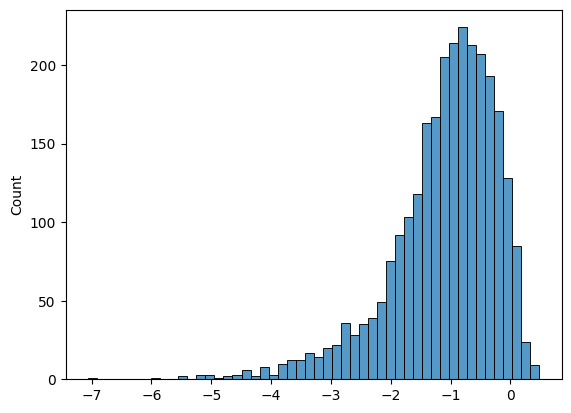

In [116]:
sns.histplot(diff[8,5])

In [112]:
diff = torch.load("../results/gpt2_examples_diff.pt")

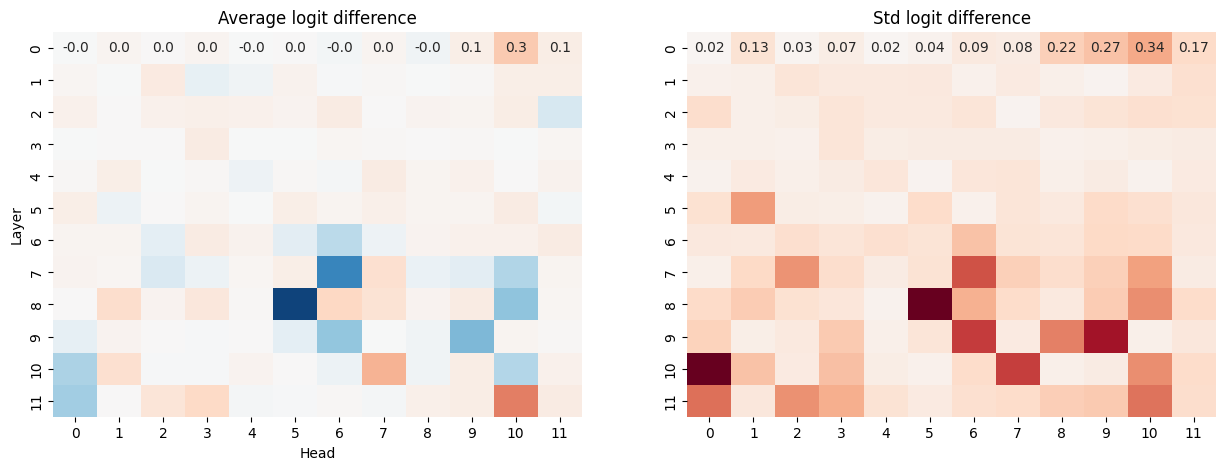

In [5]:
plot_heatmaps(diff.mean(-1), diff.std(-1), title="ciao", interval=1.2)

## Attention pattern

In [3]:
#! TODO : analizzare da dove vengono i valori
pattern = AttentionPattern(dataset,model, 50)

In [ ]:
pat = pattern.attention_pattern_all_len()

In [21]:
pat = pattern.get_attention_pattern_single_len(11, aggregate=True)

Attention pattern at len 11:   0%|          | 0/1 [00:00<?, ?it/s]Attention pattern at len 11: 100%|██████████| 1/1 [00:00<00:00, 49.59it/s]


In [29]:
import circuitsvis as cv
tokens = ["--", "subject_1_1", "subject_1_2", "subject_1_3", "--", "pre", "definition", "post_definition",  "subject_2_1", "subject_2_2", "subject_2_3", "--","last"]
cv.attention.attention_patterns(tokens=tokens, attention=pat.mean(0)[9]) 

In [ ]:
ov_circuit = OVCircuit(dataset,model, 20)
copy_score = ov_circuit.compute_copy_score_all_heads(resid_layer_input=7, resid_pos="definition", target="diff", logit_score=True)

In [5]:
ov = pattern.get_ov_matrix(8,5)

In [37]:
(torch.matmul(model.W_U.T, ov)).shape

torch.Size([50257, 768])

In [30]:
(model.W_E)[72,:].unsqueeze(0).shape

torch.Size([1, 768])

In [62]:
batch["target"][0]

tensor([36477, 20182], device='cuda:0')

In [63]:
mem_token = 36477
copy_token = 20182

effective = pattern.get_ov_output(8,5, mem_token)
print(effective.max(-1))
print(effective[0,0,mem_token])

effective = pattern.get_ov_output(8,5, copy_token)
print(effective.max(-1))
print(effective[0,0,copy_token])

effective = pattern.get_ov_output(8,5, mem_token)
print(effective.max(-1))
print(effective[0,0,copy_token])

effective = pattern.get_ov_output(8,5,copy_token )
print(effective.max(-1))
print(effective[0,0,mem_token])



torch.return_types.max(
values=tensor([[43.1174]], device='cuda:0'),
indices=tensor([[48476]], device='cuda:0'))
tensor(-9.3838, device='cuda:0')
torch.return_types.max(
values=tensor([[36.6380]], device='cuda:0'),
indices=tensor([[48476]], device='cuda:0'))
tensor(-0.8122, device='cuda:0')
torch.return_types.max(
values=tensor([[43.1174]], device='cuda:0'),
indices=tensor([[48476]], device='cuda:0'))
tensor(-0.4664, device='cuda:0')
torch.return_types.max(
values=tensor([[36.6380]], device='cuda:0'),
indices=tensor([[48476]], device='cuda:0'))
tensor(-8.9895, device='cuda:0')


In [77]:
batch = pattern.get_batch(17)

In [78]:
out= pattern.get_ov_interaction(8,5,batch["target"], return_full_output=False, rescale_to_standard=False)

In [82]:
print(out[:,1,0].mean(0))
print(out[:,1,0].std(0))

tensor(-4.0843, device='cuda:0')
tensor(5.7995, device='cuda:0')


In [79]:
out

tensor([[[  7.4887,   3.9484],
         [  3.9109,   3.6333]],

        [[ -8.8964, -13.8183],
         [ -3.5734,  -3.5714]],

        [[  0.5446,  -2.5610],
         [-12.7688, -10.9096]],

        [[  4.5431,   2.8272],
         [ -7.6047,  -4.5571]],

        [[-18.2353, -11.8087],
         [  1.0725,  -1.9674]],

        [[  4.8977,   2.2265],
         [ -5.4895,  -0.8663]],

        [[ -3.6837,  -2.6749],
         [-13.5628,  -8.8964]],

        [[  7.4887,   2.7126],
         [  1.1839,  -0.8122]],

        [[ -3.6837,  -1.2132],
         [ -5.0113,  -4.1617]],

        [[ -4.9312,   0.0597],
         [ -1.1908,   3.6333]],

        [[  7.4887,   3.6368],
         [ -1.4620,   0.3676]],

        [[  0.1677,  -3.6785],
         [-13.7087, -15.0334]],

        [[-10.1242,  -9.2916],
         [-11.9112, -12.5451]],

        [[  7.4887,   6.4233],
         [  0.2186,   2.1770]],

        [[ -0.8663,   1.9796],
         [  2.5491,   7.4887]],

        [[  4.8977,   6.6059],
         

torch.Size([50, 2, 50257])
tensor(1.1022, device='cuda:0')


<Axes: ylabel='Count'>

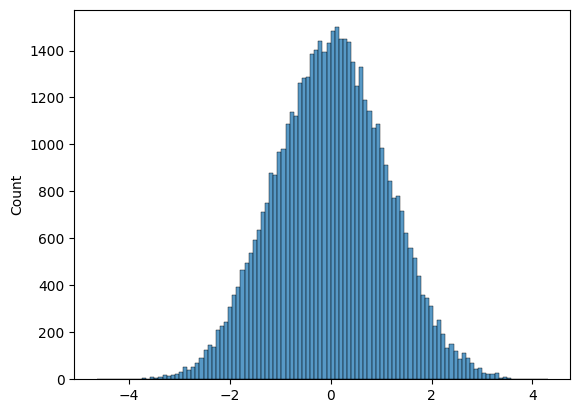

In [39]:
print(out.shape)
import seaborn as sns
print(out[8,1,:].std())
sns.histplot(out[8,1,:].cpu())